# Using Python For Research Final Project
#### _M. Atakan Barut_


# 1. Introduction


This project will predict the type of physical activity (standing, walking, stairs down, stairs up) from smartphone accelerometer data. Different physical activities give rise to different patterns of acceleration. Accelerometer data is 3 dimensional and mapped to 4 different activity. A model will be created for classifying data. The model will create spectogram of time series and classify with Linear Discriminant Analysis, then apply a gaussian filter to predictions. The model gets 99% train accuracy and 81% test accuracy. Also the model is very fast, calculating predictions takes 0.01 seconds.

## 1.1. Imports

First, importing all the packages that this project will need.
- **time** for measuring runtime of classifier
- **dateutil.parser** for parsing UTC time
- **numpy** is the fundamental package for scientific computing
- **pandas** for reading/writing csv and manipulating data
- **matplotlib** for plotting graphs
- **scipy** for calculating spectogram of time series and applying gaussian filter
- **sklearn** for classifying time series

In [1]:
import time
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# 2. Method

## 2.1. Data Cleaning/Exploration

The dataset consists of 4 files.
- `train_time_series.csv` contains accelerometer data and will be used for training
- `train_labels.csv` contains activity labels for every 10th accelerometer data and will be used for training
- `train_time_series.csv` contains accelerometer data and will be used for testing
- `train_time_series.csv` contains activity labels for every 10th accelerometer data and will be used for testing

Below code block will download these files.

In [2]:
# Download dataset
base_url = 'https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2020+type@asset+block/'
df_train_time_series = pd.read_csv(base_url + 'train_time_series.csv', index_col=0)
df_train_labels = pd.read_csv(base_url + 'train_labels.csv', index_col=0)
df_test_time_series = pd.read_csv(base_url + 'test_time_series.csv', index_col=0)
df_test_labels = pd.read_csv(base_url + 'test_labels.csv', index_col=0)

Peeking dataset.

`time_series` has following columns:

timestamp, UTC time, accuracy, x, y, z

`labels` has following columns:

timestamp, UTC time, label

Labels are numbered with integers:

1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up.

In [3]:
df_train_time_series

,timestamp,UTC time,accuracy,x,y,z
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450
...,...,...,...,...,...,...
24325,1565110305638,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304
24326,1565110305738,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213
24327,1565110305838,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713
24328,1565110305939,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805


In [4]:
df_train_labels

,timestamp,UTC time,label
20589,1565109931087,2019-08-06T16:45:31.087,1
20599,1565109932090,2019-08-06T16:45:32.090,1
20609,1565109933092,2019-08-06T16:45:33.092,1
20619,1565109934094,2019-08-06T16:45:34.094,1
20629,1565109935097,2019-08-06T16:45:35.097,1
...,...,...,...
24289,1565110302030,2019-08-06T16:51:42.030,4
24299,1565110303032,2019-08-06T16:51:43.032,4
24309,1565110304034,2019-08-06T16:51:44.034,4
24319,1565110305037,2019-08-06T16:51:45.037,4


In [5]:
df_test_time_series

,timestamp,UTC time,accuracy,x,y,z
24330,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623
24331,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975
24332,1565110306340,2019-08-06T16:51:46.340,unknown,-0.234390,-0.984558,0.124771
24333,1565110306440,2019-08-06T16:51:46.440,unknown,0.251114,-0.787003,0.054810
24334,1565110306540,2019-08-06T16:51:46.540,unknown,0.109924,-0.169510,0.235550
...,...,...,...,...,...,...
25575,1565110430975,2019-08-06T16:53:50.975,unknown,0.036499,-0.724823,0.553802
25576,1565110431075,2019-08-06T16:53:51.075,unknown,-0.159241,0.307022,0.142410
25577,1565110431175,2019-08-06T16:53:51.175,unknown,-0.037964,-0.673706,1.065445
25578,1565110431275,2019-08-06T16:53:51.275,unknown,0.255707,-1.485397,-0.013336


In [6]:
df_test_labels

,timestamp,UTC time,label
24339,1565110307041,2019-08-06T16:51:47.041,NaN
24349,1565110308043,2019-08-06T16:51:48.043,NaN
24359,1565110309046,2019-08-06T16:51:49.046,NaN
24369,1565110310048,2019-08-06T16:51:50.048,NaN
24379,1565110311050,2019-08-06T16:51:51.050,NaN
...,...,...,...
25539,1565110427366,2019-08-06T16:53:47.366,NaN
25549,1565110428369,2019-08-06T16:53:48.369,NaN
25559,1565110429371,2019-08-06T16:53:49.371,NaN
25569,1565110430373,2019-08-06T16:53:50.373,NaN


The dataset has following properties:
- time_series is unknown for all values
- UTC time is equal to timestamp
- Timestamp values are continuous, there is no pause between values
- Test data is after train data, there is no pause between train and test dataset

Below code checks above properties.

In [7]:
def check_assumptions(df_time_series, df_labels):
    '''Checks assumptions of data'''
    # Accuracy is unknown for all values
    assert (df_time_series['accuracy'] == 'unknown').all()
    # UTC time equal to timestamp (time_series)
    assert (df_time_series['UTC time'].map(dateutil.parser.parse)
        .map(lambda dt: int(dt.timestamp()*1000)) == df_time_series['timestamp']).all()
    # UTC time equal to timestamp (labels)
    assert (df_labels['UTC time'].map(dateutil.parser.parse)
        .map(lambda dt: int(dt.timestamp()*1000)) == df_labels['timestamp']).all()
    # Timestamp values are continuous (time_series)
    assert (df_time_series['timestamp'].diff().fillna(0) < 200).all()
    # Timestamp values are continuous (labels)
    assert (df_labels['timestamp'].diff().fillna(0) < 2000).all()
    # Timestamp values matches between time_series and labels
    assert (df_time_series.loc[df_labels.index]['timestamp'] == df_labels['timestamp']).all()

check_assumptions(df_train_time_series, df_train_labels)
check_assumptions(df_test_time_series, df_test_labels)

Only accelometer values from 3 dimensions (x, y, z) is needed for classifying labels.

In [8]:
train_time_series = df_train_time_series[['x', 'y', 'z']]
train_labels = df_train_labels['label']
test_time_series = df_test_time_series[['x', 'y', 'z']]
test_labels = df_test_labels['label']
print(train_time_series.shape, train_labels.shape, test_time_series.shape, test_labels.shape)

(3744, 3) (375,) (1250, 3) (125,)


Shapes are not matched, because train_time_series starts at `20586` and train_labels starts at `20589`. It should started at `20580` but data is not provided. So first label will be removed in training data.

In [9]:
time_series_start = train_time_series.index[0]
labels_start = train_labels.index[0]
train_time_series = train_time_series[labels_start - time_series_start + 1:]
train_labels = train_labels[1:]

Now shapes and indexes are matched.

In [10]:
# Every label matched with 10th index of time series
assert (train_time_series[10-1::10].index == train_labels.index).all()
assert (test_time_series[10-1::10].index == test_labels.index).all()
# Length of the time series is multiple of 10
assert train_time_series.shape[0] % 10 == 0
assert test_time_series.shape[0] % 10 == 0
# Length of the labels and time series are same
assert train_time_series.shape[0] // 10 == train_labels.shape[0]
assert test_time_series.shape[0] // 10 == test_labels.shape[0]
print(train_time_series.shape, train_labels.shape, test_time_series.shape, test_labels.shape)

(3740, 3) (374,) (1250, 3) (125,)


Calculating how labels are changing.

Labels changed 9 times in training data and changes per 46 seconds in average. 

In [11]:
label_change = np.argwhere((train_labels != train_labels.shift()).to_numpy()).flatten()
print('Labels changing at', label_change)
mean_label_width = int(np.round(np.mean(np.diff(label_change))))
print('Mean label width:', mean_label_width)

Labels changing at [  0   8  96 133 151 185 233 287 364]
Mean label width: 46


## 2.2. Visualization

Before visualizing any data, figure size and colors need to be set.

Figure size set to 16x16 inches. Figure size can be adjusted for any screen.

In [12]:
plt.rcParams['figure.figsize'] = (16, 16)

These colors will be used for labels:
- **green** as standing
- **blue** as walking
- **red** as down-stairs
- **orange** as up-stairs
- **brown** as unknown (test labels)

In [13]:
colors = ['#4CAF50', '#2196F3', '#F44336', '#FF9800', '#795548']

These are utility functions for visualizing dataset.
- **plot_time_acceleration** creates scatter plot using accelometer values with 3 dimensions
- **plot_time_frequency** creates spectrogram of accelometer values with 3 dimensions
- **merge_dataset** merges train and test dataset for plotting all data
- **to_frequencies** converts time series to frequencies with calculating spectrogram of values

In [14]:
def plot_time_acceleration(train_time_series, train_labels, test_time_series, test_labels):
    '''Creates scatter plot using accelometer values with 3 dimensions'''
    all_dataset = merge_dataset(train_time_series, train_labels, test_time_series, test_labels)
    fig, axs = plt.subplots(3)
    for i, dimension in enumerate(['x', 'y', 'z']):
        # Plot points
        axs[i].scatter(
            x=np.arange(len(all_dataset)),
            y=all_dataset[dimension],
            c=all_dataset.label.map(lambda x: colors[4 if np.isnan(x) else int(x)-1]),
        )
        # Set axis labels
        axs[i].set(
            xticks=np.arange(0, len(all_dataset), 200),
            xlabel='Time (0.1 s)',
            ylabel=f'Accelometer {dimension.upper()} ($m/s^2$)'
        )
    fig.show()

def plot_time_frequency(train_time_series, train_labels, test_time_series, test_labels):
    '''Creates spectrogram of accelometer values with 3 dimensions'''
    all_dataset = merge_dataset(train_time_series, train_labels, test_time_series, test_labels)
    fig, axs = plt.subplots(3)
    for i, dimension in enumerate(['x', 'y', 'z']):
        Sxx = to_frequencies(all_dataset[dimension])
        # Draw frequencies
        axs[i].pcolormesh(
            np.arange(len(all_dataset) // 10),
            np.linspace(0, 5, Sxx.shape[0]),
            Sxx,
            shading='gouraud',
        )
        # Draw labels
        axs[i].scatter(
            x=np.arange(len(all_dataset) // 10),
            y=np.zeros(len(all_dataset) // 10),
            s=128,
            marker='s',
            c=all_dataset.iloc[::10, :].label.map(lambda x: colors[4 if np.isnan(x) else int(x)-1]),
        )
        # Set axis labels and ticks
        axs[i].set(
            xticks=np.arange(0, len(all_dataset) // 10, 20),
            xlabel='Time (s)',
            ylabel=f'Accelometer {dimension.upper()} Frequency (Hz)'
        )
    fig.show()

def merge_dataset(train_time_series, train_labels, test_time_series, test_labels):
    '''Merges all dataset for visualizing purposes'''
    # Merge time series and labels
    train_dataset = train_time_series.join(train_labels)
    # Fill intermediate labels
    train_dataset = train_dataset.interpolate('nearest')
    # Fill first labels
    train_dataset = train_dataset.fillna(method='bfill')
    # Merge time series and labels
    test_dataset = test_time_series.join(test_labels)
    # Fill intermediate labels
    test_dataset = test_dataset.interpolate('nearest')
    # Fill first labels
    test_dataset = test_dataset.fillna(method='bfill')
    # Merge train and test
    return train_dataset.append(test_dataset)

def to_frequencies(time_series, segments=mean_label_width):
    '''Converts time series to frequencies'''
    f, t, Sxx = signal.spectrogram(
        np.pad(time_series, segments-5),
        fs=10, nperseg=segments*2, noverlap=segments*2-10)

    # Subtract padding
    t -= segments / 10

    # Check assumptions
    assert np.allclose(f, np.linspace(0, 5, segments + 1))
    assert np.allclose(t, np.arange(len(time_series) / 10))
    assert Sxx.shape == (len(f), len(t))

    return Sxx

Plotting all accelometer values.

There is a time-acceleration graph for all data. Data has 499 seconds of activity, 374 s for training 125 s for testing. Data has 4 labels and they are standing (green), walking (blue), down-stairs (red), up-stairs (orange). Test labels are not provided so they are brown.

Labels are changing per 46 seconds in average. Labels changed 9 times in training data. Although test labels are not provided, it appears that labels are changed 4 times in test data.

Standing (green) values can be easily seperated, because their variance is low.
Walking (blue) is seperated, because their variance is high.
But stairs down (red) and stairs up (orange) is hard to seperate.
A better method needed for classify them.

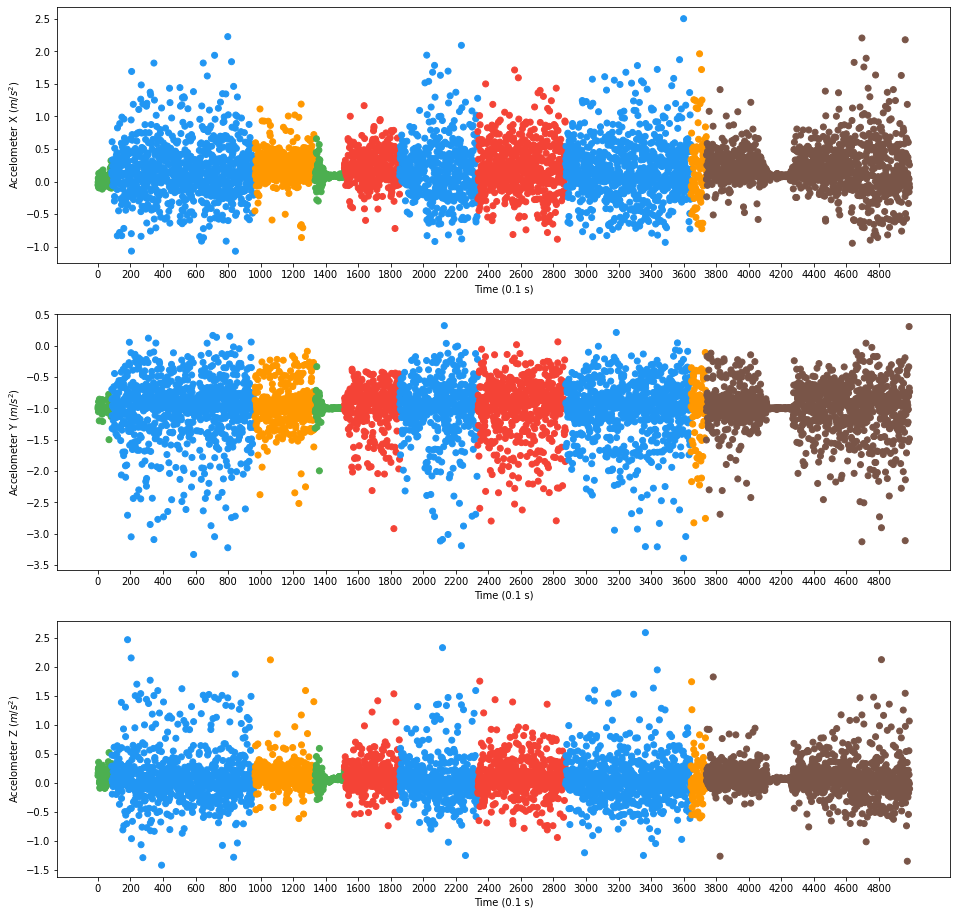

In [15]:
plot_time_acceleration(train_time_series, train_labels, test_time_series, test_labels)

Creating spectrogram for classifying data.

It is more easy to seperate labels. In walking (blue), it has high frequencies. In standing (green), frequencies are not strong. In stairs up (orange), there are some low frequencies which stairs down (red) hasn't.

Spectrogram data can be used for classification input.

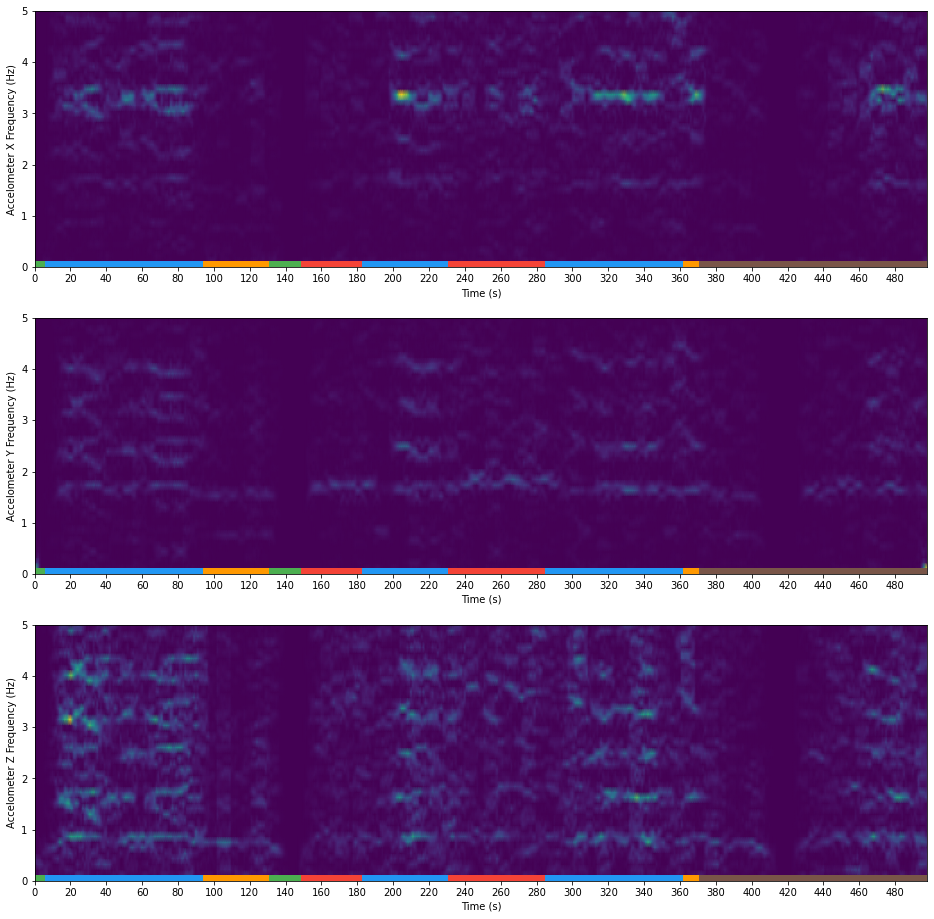

In [16]:
plot_time_frequency(train_time_series, train_labels, test_time_series, test_labels)

## 2.3. Model

Classifier model will be built in this section. The model will first calculate spectrogram of accelometer values, then use Linear Discriminant Analysis (LDA), after that it will apply a gaussian filter to predictions.

The model's pipeline is constructed as follows:

1. Calculate spectrogram of accelometer values for each dimension (x, y, z). `FunctionTransformer` and utility function `to_frequencies` will be used.

2. Use Linear Discriminant Analysis (LDA) for classifying accelometer values. LDA is used for dimensionality reduction but can be used for classification tasks. LDA finds a linear combination of features that separates classes.

3. Apply gaussian filter to predictions. Predictions can change very fast over time like `[2,2,2,1,2,2,2]` (that `1` value should be `2`). If a filter applied, predictions will change slowly (`[2,2,2,1,2,2,2]` become `[2,2,2,2,2,2,2]`). <br> This step can't be added directly to `Pipeline`, because filter will be applied to `predict_proba`. So a helper class called `FunctionTransformedClassifier` created for applying filter.

In [17]:
class FunctionTransformedClassifier(BaseEstimator, ClassifierMixin):
    '''Constructs a classifier that applies a function to predictions.'''
    def __init__(self, classifier, func):
        self.classifier = classifier
        self.func = func

    def fit(self, X, y):
        '''Fit provided classifier.'''
        self.classifier.fit(X, y)
        return self

    def predict(self, X):
        '''Perform classification on samples in X by applying function to predictions from classifier.'''
        y_predict_proba = self.classifier.predict_proba(X)
        y_transformed = self.func(y_predict_proba)
        indices = y_transformed.argmax(axis=1)
        return self.classifier.classes_[indices]

In [18]:
classifier = Pipeline([
    # Convert time series to frequencies
    ('ft', FunctionTransformer(
        func=lambda ts: np.concatenate(
            (to_frequencies(ts.x), to_frequencies(ts.y), to_frequencies(ts.z))
        ).T,
    )),
    # Use LDA classifier and apply gaussian filter to predictions
    ('lda', FunctionTransformedClassifier(
        classifier=LinearDiscriminantAnalysis(),
        func=lambda y: gaussian_filter1d(y, 10, axis=0),
    ))
])
classifier.fit(train_time_series, train_labels)
print('Train accuracy:', classifier.score(train_time_series, train_labels))

Train accuracy: 0.9866310160427807


# 3. Results

Getting 99% training accuracy is good. Testing predictions are submitted and gets 81% testing accuracy.

## 3.1. Visualization of Predictions

Predictions are good looking. Prediction labels changes 4 times in test set. Starts with stairs up (orange), then standing (green), stairs down (red), walking (blue).

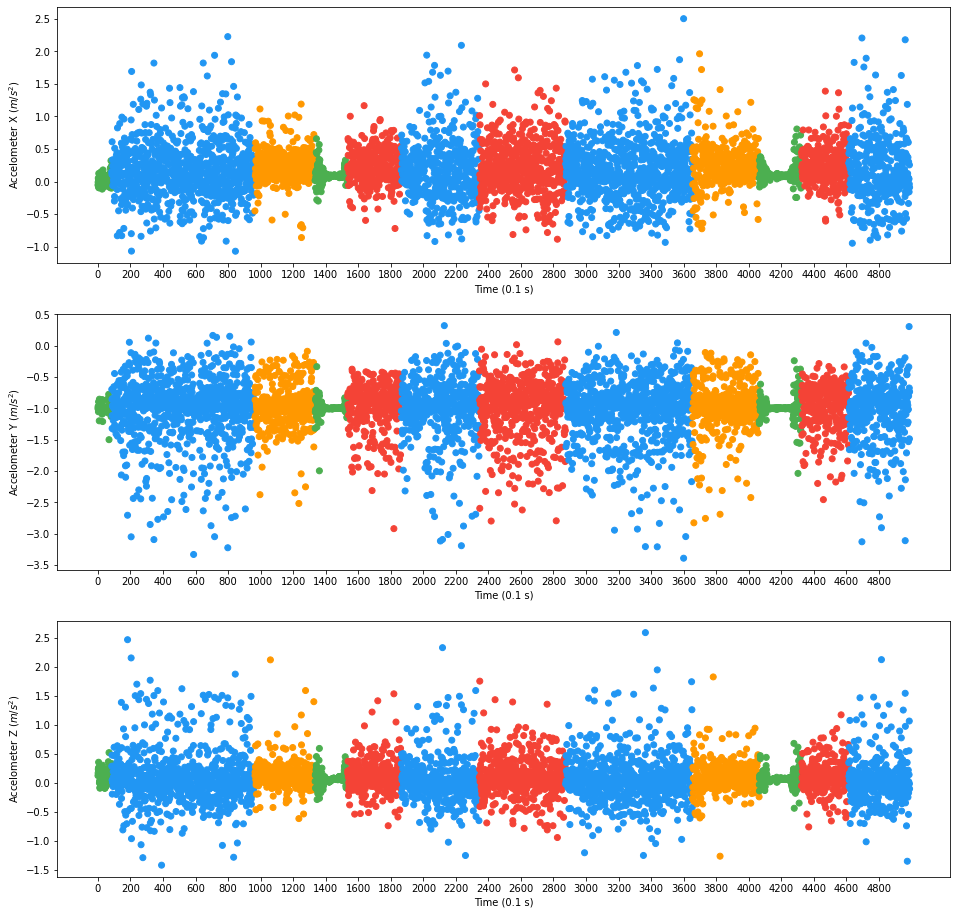

In [19]:
plot_time_acceleration(
    train_time_series,
    pd.Series(classifier.predict(train_time_series), train_labels.index, name=train_labels.name),
    test_time_series,
    pd.Series(classifier.predict(test_time_series), test_labels.index, name=test_labels.name),
)

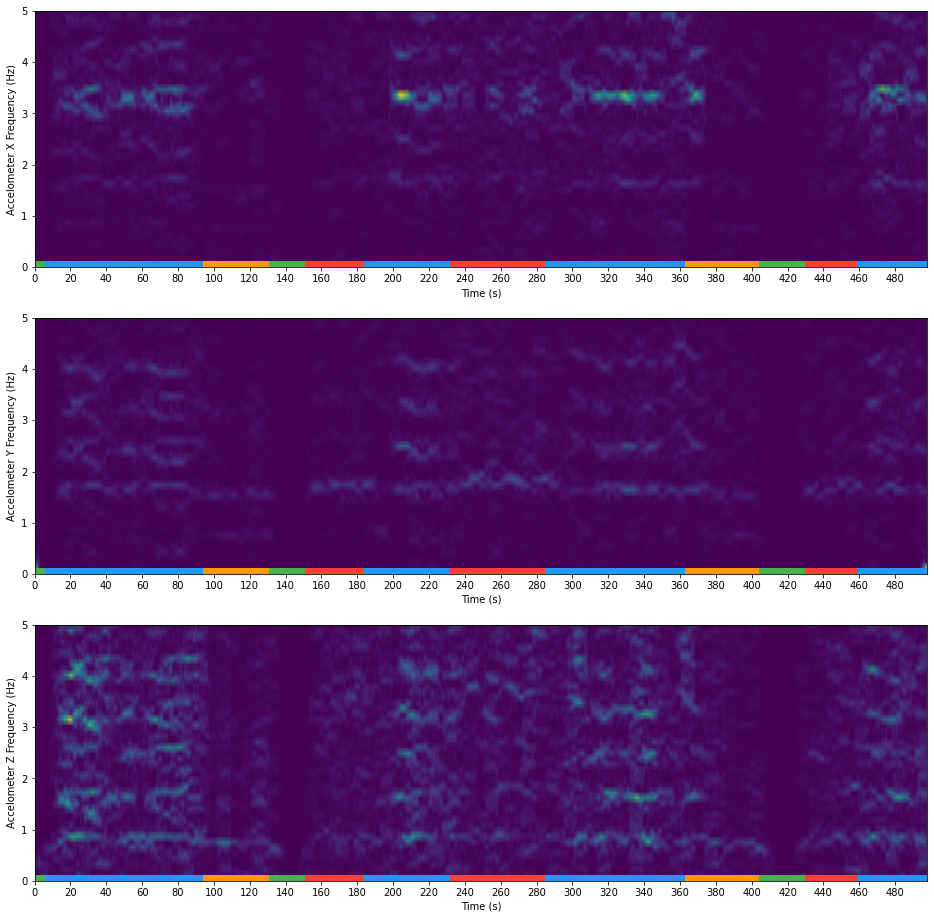

In [20]:
plot_time_frequency(
    train_time_series,
    pd.Series(classifier.predict(train_time_series), train_labels.index, name=train_labels.name),
    test_time_series,
    pd.Series(classifier.predict(test_time_series), test_labels.index, name=test_labels.name),
)

## 3.2. Model Performance
Calculating running time of the model for model performance. Timing starts when test dataset loaded and stops when predictions are computed. The model is implemented as `Pipeline` so only `predict` needs to be called.

0.01 seconds is very good for classifying accelometer data. This classifier can be used in real time applications.

In [21]:
start_time = time.time()
classifier.predict(test_time_series)
stop_time = time.time()
print('Elapsed time:', np.round(stop_time - start_time, 2), 'seconds')

Elapsed time: 0.01 seconds


This code block is for submission. Prints predictions, compares previous submission for reproducibility, saves to `test_labels.csv`.

In [22]:
y_pred = classifier.predict(test_time_series)

# Print predictions for submission
print(*y_pred, sep=',')

# Copy of submission
submission = [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]

# Compare previous submission with current predictions for reproducibility
assert (y_pred == submission).all()

# Save predictions to test_labels.csv
df_test_labels = pd.read_csv(base_url + 'test_labels.csv', index_col=0)
df_test_labels['label'] = y_pred
df_test_labels.to_csv('test_labels.csv')

# Check file saved successfully
df_test_labels = pd.read_csv('test_labels.csv', index_col=0)
assert (df_test_labels['label'] == y_pred).all()

4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


# Conclusion


The purpose of this project is predicting physical activity (standing, walking, stairs down, stairs up) from accelerometer data. Dataset visualized  as scatter plot and spectrogram graph. A model pipeline built for classification. The pipeline calculated spectrogram of accelometer values for each dimension, then used Linear Discriminant Analysis (LDA) and applied gaussian filter. The model got 99% train accuracy and 81% test accuracy. Predictions are visualized and they looked well-fitted. The model's runtime calculated, it was very fast and it took 0.01 seconds.